In [1]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
import ast
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib import pyplot as plt
import os
from datetime import datetime

In [2]:
# 方便复现结果
def set_all_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # 如果使用 GPU，也需要固定 CUDA 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果有多个 GPU
set_all_seed(42)

In [3]:
# 前25个特征是离散特征，后13个特征是连续特征
df_train=pd.read_csv("data/exp1/raw_train.csv")
df_test=pd.read_csv("data/exp1/raw_test.csv")

In [4]:
df_train['vectorized_features_1'] = df_train['vectorized_features_1'].apply(ast.literal_eval)
df_test['vectorized_features_1'] = df_test['vectorized_features_1'].apply(ast.literal_eval)

In [5]:
# 获取训练数据
x_train=torch.from_numpy(np.array(df_train['vectorized_features_1'].values.tolist(),np.float32))
x_train_d=x_train[:,:25].long() # 前25维是离散变量(discrete)，要转为long类型才能送入embedding层
x_train_c=x_train[:,25:] # 中间13维是连续变量(continuous), 最后一维是0或1，也当做连续变量
y1_train=torch.from_numpy(np.array(df_train['income'].values.tolist(),np.float32))
y2_train=torch.from_numpy(np.array(df_train['AMARITL'].values.tolist(),np.float32))

print(x_train_d)
print(x_train_d.shape)
print(x_train_c)
print(x_train_c.shape)
print(y1_train)
print(y1_train.shape)
print(y2_train)
print(y2_train.shape)

tensor([[2, 6, 6,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 5,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [5, 7, 3,  ..., 0, 0, 0]])
torch.Size([95130, 25])
tensor([[58.,  4., 34.,  ..., 52., 94.,  0.],
        [ 9.,  0.,  0.,  ...,  0., 94.,  0.],
        [10.,  0.,  0.,  ...,  0., 94.,  0.],
        ...,
        [51., 33., 19.,  ..., 52., 94.,  0.],
        [ 3.,  0.,  0.,  ...,  0., 94.,  0.],
        [65., 37.,  2.,  ..., 52., 94.,  0.]])
torch.Size([95130, 14])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([95130])
tensor([0., 1., 1.,  ..., 0., 1., 0.])
torch.Size([95130])


计算两个任务的标签间的pearson相关系数

In [6]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(y1_train, y2_train)
print(f"Absolute Pearson correlation coefficient: {abs(corr)}") # 符合原论文的0.1768
print(f"P-value: {p_value}")

Absolute Pearson correlation coefficient: 0.17716269850240274
P-value: 0.0


In [7]:
# 获取测试数据
x_test=torch.from_numpy(np.array(df_test['vectorized_features_1'].values.tolist(),np.float32))
x_test_d=x_test[:,:25].long() # 前25维是离散变量(discrete)，要转为long类型才能送入embedding层
x_test_c=x_test[:,25:] # 中间13维是连续变量(continuous), 最后一维是0或1，也当做连续变量
y1_test=torch.from_numpy(np.array(df_test['income'].values.tolist(),np.float32))
y2_test=torch.from_numpy(np.array(df_test['AMARITL'].values.tolist(),np.float32))

print(x_test_d)
print(x_test_d.shape)
print(x_test_c)
print(x_test_c.shape)
print(y1_test)
print(y1_test.shape)
print(y2_test)
print(y2_test.shape)

tensor([[ 1,  9,  4,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 1,  3,  1,  ...,  0,  0,  0],
        [ 2, 14, 10,  ...,  1,  2,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])
torch.Size([47391, 25])
tensor([[35., 29.,  3.,  ..., 52., 94.,  0.],
        [13.,  0.,  0.,  ...,  0., 94.,  0.],
        [ 1.,  0.,  0.,  ...,  0., 94.,  0.],
        ...,
        [22., 43., 26.,  ..., 52., 94.,  1.],
        [24.,  1., 43.,  ..., 52., 94.,  0.],
        [67.,  0.,  0.,  ...,  0., 94.,  0.]])
torch.Size([47391, 14])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([47391])
tensor([0., 1., 1.,  ..., 1., 0., 0.])
torch.Size([47391])


In [8]:
class MyDataset(Dataset):
    def __init__(self,x_discrete,x_continuous,y1,y2):
        self.x_d=x_discrete
        self.x_c=x_continuous
        self.y1=y1
        self.y2=y2
    def __len__(self):
        return self.x_d.shape[0]
    def __getitem__(self,idx):
        return (self.x_d[idx],self.x_c[idx],self.y1[idx],self.y2[idx])

In [9]:
# 训练集
train_dataset=MyDataset(x_train_d,x_train_c,y1_train,y2_train)
# 验证集和测试集按照原论文1:1
val_dataset=MyDataset(x_test_d[:23695],x_test_c[:23695],y1_test[:23695],y2_test[:23695])
test_dataset=MyDataset(x_test_d[23695:47390],x_test_c[23695:47390],y1_test[23695:47390],y2_test[23695:47390])

In [10]:
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim, expert_dropout):  # input_dim代表输入维度，output_dim代表输出维度
        super(Expert, self).__init__()

        expert_hidden_layers = [64, 32]
        self.expert_layer = nn.Sequential(
            nn.Linear(input_dim, expert_hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[0], expert_hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[1], output_dim),
            nn.ReLU(),
            nn.Dropout(expert_dropout)
        )

    def forward(self, x):
        out = self.expert_layer(x)
        return out


class Expert_Gate(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)  use_gate：是否使用门控，如果不使用则各个专家取平均
    def __init__(self, feature_dim, expert_dim, n_expert, n_task, expert_dropout, gate_dropout,use_gate=True):  
        super(Expert_Gate, self).__init__()
        self.n_task = n_task
        self.use_gate = use_gate
        self.n_expert = n_expert

        '''专家网络'''
        for i in range(n_expert):
            setattr(self, "expert_layer" + str(i + 1), Expert(feature_dim, expert_dim, expert_dropout))
        self.expert_layers = [getattr(self, "expert_layer" + str(i + 1)) for i in range(n_expert)]  # 为每个expert创建一个DNN

        '''门控网络'''
        for i in range(n_task):
            setattr(self, "gate_layer" + str(i + 1), nn.Sequential(nn.Linear(feature_dim, n_expert), 
                                                                   nn.Dropout(gate_dropout),
                                                                   nn.Softmax(dim=1)))
        self.gate_layers = [getattr(self, "gate_layer" + str(i + 1)) for i in range(n_task)]  # 为每个gate创建一个lr+softmax

    def forward(self, x):
        if self.use_gate:
            # 多个专家网络的输出
            E_net = [expert(x) for expert in self.expert_layers]
            E_net = torch.cat(([e[:, np.newaxis, :] for e in E_net]), dim=1)  # (b,n_expert,expert_dim)

            # 多个门网络的输出
            gate_net = [gate(x) for gate in self.gate_layers]  # n_task个(b,n_expert)
            
            # 记录每个batch内第一个样本的门网络的输出
            for i in range(self.n_task):
                for j in range(self.n_expert):
                    writer.add_scalar(f"task_{i}/expert_{j}_weight", gate_net[i][0][j], tot_iters)

            # towers计算：对应的门网络乘上所有的专家网络
            towers_input = []
            for i in range(self.n_task):
                g = gate_net[i].unsqueeze(2)  # (b,n_expert,1)
                tower_input = torch.matmul(E_net.transpose(1, 2), g)  # (b,d,n_expert)@(b,n_expert,1)-->(b,expert_dim,1)
                towers_input.append(tower_input.squeeze(2))  # (b, expert_dim)
        else:
            E_net = [expert(x) for expert in self.expert_layers]
            towers_input = sum(E_net) / len(E_net)
        return towers_input

In [11]:
class MMoE(nn.Module):
    # feature_dim:输入数据的维数  expert_dim:每个神经元输出的维数  n_expert:专家数量  n_task:任务数(gate数)
    def __init__(self, feature_dim, expert_dim, n_expert, n_task, use_gate=True, tower_dropout=0, expert_dropout=0, gate_dropout=0):
        super(MMoE, self).__init__()

        self.n_task = n_task
        self.use_gate = use_gate
        self.Expert_Gate = Expert_Gate(feature_dim=feature_dim, expert_dim=expert_dim, n_expert=n_expert, n_task=n_task,
                                       expert_dropout=expert_dropout, gate_dropout=gate_dropout, use_gate=use_gate)

        # 对于离散变量做embedding
        # 25种离散变量
        vocab_size_list = [9,24,15,5,10,2,3,6,1,6,6,50,37,8,9,8,9,3,3,5,40,40,41,5,3]
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=i, embedding_dim=4) for i in vocab_size_list
        ])
        # 合计送入expert的维度为:25*4+14=114

        # 顶层的任务塔
        hidden_layer1 = [64, 32]
        self.towers=nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, hidden_layer1[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer1[0], hidden_layer1[1]),
                nn.ReLU(),
                nn.Dropout(tower_dropout),
                nn.Linear(hidden_layer1[1], 1))
            for i in range(n_task)
        ])
        
        self.sigmoid=nn.Sigmoid()

    def forward(self, x_d, x_c):
        temp = []
        for i in range(len(self.embeddings)):
            temp.append(self.embeddings[i](x_d[:, i]))
        temp = temp + [x_c]
        x = torch.cat(temp, dim=-1)

        towers_input = self.Expert_Gate(x)

        outputs = []
        if self.use_gate:
            for i in range(self.n_task):
                outputs.append(self.sigmoid(self.towers[i](towers_input[i])))
        else:
            for i in range(self.n_task):
                outputs.append(self.sigmoid(self.towers[i](towers_input)))

        return outputs

In [12]:
# model config
feature_dim=114
expert_dim=32
n_expert=4
n_task=2
use_gate=True
gate_dropout=0.2
tower_dropout=0
expert_dropout=0

In [13]:
mmoe = MMoE(feature_dim=feature_dim,expert_dim=expert_dim,n_expert=n_expert,n_task=n_task,use_gate=use_gate, gate_dropout=gate_dropout, expert_dropout=expert_dropout, tower_dropout=tower_dropout)

nParams = sum([p.nelement() for p in mmoe.parameters()])
print('Number of parameters: %d' % nParams)

Number of parameters: 52746


In [14]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [15]:
if not os.path.exists("model/exp1/"):
    os.makedirs("model/exp1/") 

In [16]:
def train(mymodel, lr, N_epochs, batch_size):
    global writer
    log_dir = os.path.join("logs/exp1", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    writer = SummaryWriter(log_dir=log_dir)
    global tot_iters
    tot_iters = 0
    mymodel = mymodel.to(device)
    loss_fun = nn.BCELoss()
    optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
    adam_batch_loss = []
    losses = []
    val_losses = []
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(N_epochs):
        # train loop
        batch_loss = []
        mymodel.train()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in train_dataloader:
            tot_iters+=1
            
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            y1_pred, y2_pred = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)
            
            loss1 = loss_fun(y1_pred, y1_batch)
            loss2 = loss_fun(y2_pred, y2_batch)
            writer.add_scalar(f"loss1", loss1, tot_iters)
            writer.add_scalar(f"loss2", loss2, tot_iters)
            loss = loss1+loss2  # 此处令两个任务的损失值权重均为1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record result
            adam_batch_loss.append(loss.detach().cpu().numpy())
            batch_loss.append(loss.detach().cpu().numpy())

        # val loop
        val_batch_loss = []
        mymodel.eval()
        for x_d_batch, x_c_batch, y1_batch, y2_batch in val_dataloader:
            x_d_batch = x_d_batch.to(device)
            x_c_batch = x_c_batch.to(device)
            y1_batch = y1_batch.to(device)
            y2_batch = y2_batch.to(device)

            y1_pred, y2_pred = mymodel(x_d_batch, x_c_batch)  # 两个task
            y1_pred = y1_pred.squeeze(1)
            y2_pred = y2_pred.squeeze(1)

            loss = loss_fun(y1_pred, y1_batch) + loss_fun(y2_pred, y2_batch)

            # record result
            val_batch_loss.append(loss.detach().cpu().numpy())

        # post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))

        # print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
        writer.add_scalar(f"train_loss", losses[-1], epoch)
        writer.add_scalar(f"val_loss", val_losses[-1], epoch)

        # save best model
        if (val_losses[-1] < best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(), f'model/exp1/best_model_{lr}_{N_epochs}_{batch_size}_{gate_dropout}_{expert_dropout}_{tower_dropout}')
            best_loss = val_losses[-1]
    
    writer.close()

    return losses, val_losses, adam_batch_loss

In [17]:
batch_size=64
N_epochs=50
lr=0.0001

In [18]:
losses, val_losses, adam_batch_loss= train(mymodel=mmoe, lr=lr, N_epochs=N_epochs, batch_size=batch_size)

Epoch=0,train_loss=0.5956240296363831,val_loss=0.3582952618598938
current epoch is the best so far. Saving model...
Epoch=1,train_loss=0.35639217495918274,val_loss=0.32065442204475403
current epoch is the best so far. Saving model...
Epoch=2,train_loss=0.30638518929481506,val_loss=0.30430635809898376
current epoch is the best so far. Saving model...
Epoch=3,train_loss=0.28716203570365906,val_loss=0.26823875308036804
current epoch is the best so far. Saving model...
Epoch=4,train_loss=0.2770639657974243,val_loss=0.2600609362125397
current epoch is the best so far. Saving model...
Epoch=5,train_loss=0.2686517536640167,val_loss=0.263109415769577
Epoch=6,train_loss=0.26060983538627625,val_loss=0.2665236294269562
Epoch=7,train_loss=0.25479942560195923,val_loss=0.26312366127967834
Epoch=8,train_loss=0.25028207898139954,val_loss=0.24530388414859772
current epoch is the best so far. Saving model...
Epoch=9,train_loss=0.2464369386434555,val_loss=0.24321404099464417
current epoch is the best so 

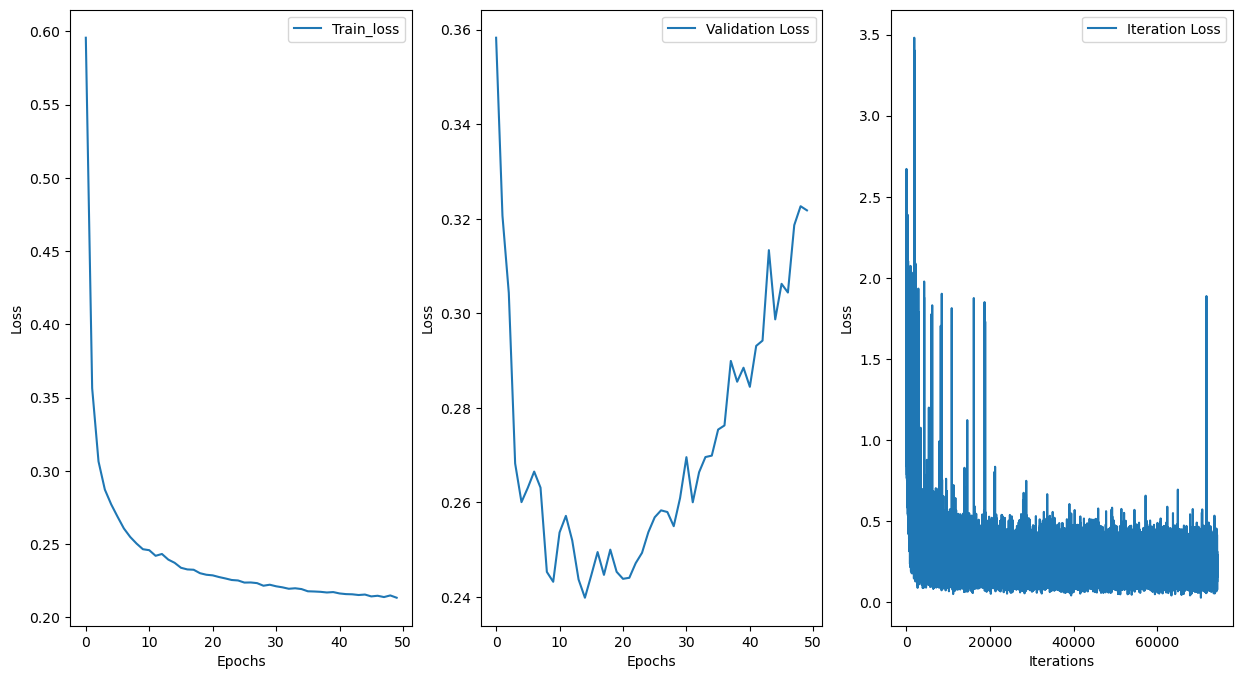

In [19]:
# visualization
fix,axes=plt.subplots(nrows=1,ncols=3,figsize=(15, 8))

axes[0].plot(range(N_epochs),losses,label="Train_loss")
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# axes[1].plot(range(N_epochs),best_model_loss[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),val_losses,label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(range(tot_iters),adam_batch_loss,label="Iteration Loss")
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Loss')
axes[2].legend()

In [20]:
# load best model based on validation
mybestmodel=MMoE(feature_dim=feature_dim,expert_dim=expert_dim,n_expert=n_expert,n_task=n_task,use_gate=use_gate)
mybestmodel.load_state_dict(torch.load(f'model/exp1/best_model_{lr}_{N_epochs}_{batch_size}_{gate_dropout}_{expert_dropout}_{tower_dropout}'))

x_test_d, x_test_c=x_test_d.to(device), x_test_c.to(device)

y1_pred,y2_pred = mmoe(x_test_d[23695:47390],x_test_c[23695:47390])

# y1_pred=(y1_pred>0.5).int()
# y2_pred=(y2_pred>0.5).int()

y1_pred=y1_pred.squeeze(1).detach().cpu().numpy()
y2_pred=y2_pred.squeeze(1).detach().cpu().numpy()

In [21]:
from sklearn.metrics import roc_curve, auc

def get_auc(y_true,y_pred):
    # 获取 ROC 曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # 计算 AUC
    calculated_auc = auc(fpr, tpr)
    print(f"Custom AUC: {calculated_auc}")
    return calculated_auc

In [22]:
# 和原论文基本一致
# 把N_epochs从10增大到50，发现task1性能显著提升
auc1=get_auc(y1_test[23695:47390],y1_pred)
auc2=get_auc(y2_test[23695:47390],y2_pred)

Custom AUC: 0.9416316171858814
Custom AUC: 0.9830408228517421


In [23]:
y1_test[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
y1_pred[:10]

array([6.1696865e-02, 5.1391527e-02, 1.7467908e-05, 1.9852783e-05,
       1.5499976e-05, 2.0480542e-02, 7.7918088e-03, 1.3886479e-01,
       2.2355842e-03, 4.4919057e-03], dtype=float32)

In [25]:
y2_pred[:10]

array([8.2342731e-06, 2.9743528e-01, 9.9999988e-01, 9.9999928e-01,
       9.9999595e-01, 5.1065956e-05, 3.1638534e-05, 1.3172858e-04,
       9.0260220e-01, 7.3719710e-02], dtype=float32)

In [26]:
y2_test[:10]

tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])